In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.utils.multiclass import unique_labels
from sklearn.svm import SVC
import numpy as np
from sklearn.preprocessing import LabelBinarizer
import scipy
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import MultinomialNB



First, we import the previously cleaned training data. We add columns for the predictions of every model (Logistic regression, KNN, Random forest, SVC, Naive Bayes) we will deploy in this notebook. The headers of those columns are of type "model_prediction". We need those columns in order to implement the voting we intend to do (don't worry if you don't understand yet what is meant by "voting"). We initialize the values of those columns to zero. 

In [3]:
traindata = pd.read_csv("trainclean.csv") 
submitdata = pd.read_csv("submitclean.csv")

traindata['KNN_prediction']=str('0')
traindata['LR_prediction']=str('0')
traindata['RF_prediction']=str('0')
traindata['SVC_prediction']=str('0')
traindata['NB_prediction']=str('0')

traindata.head()

,id,keyword,location,text,target,mean,KNN_prediction,LR_prediction,RF_prediction,SVC_prediction,NB_prediction
0,1,NaN,NaN,"['deed', 'reason', 'earthquake', 'may', 'allah...",1,1,0,0,0,0,0
1,4,NaN,NaN,"['forest', 'fire', 'near', 'la', 'ronge', 'sas...",1,1,0,0,0,0,0
2,5,NaN,NaN,"['resident', 'ask', 'shelter', 'place', 'notif...",1,1,0,0,0,0,0
3,6,NaN,NaN,"['people', 'receive', 'wildfire', 'evacuation'...",1,1,0,0,0,0,0
4,7,NaN,NaN,"['get', 'sent', 'photo', 'ruby', 'alaska', 'sm...",1,1,0,0,0,0,0


In [4]:
# we drop the column "target" and use the column "mean" instead
traindata.drop(["target"], axis=1, inplace=True)


In [5]:
# we rename the column "mean" as "target" in order to fit the submission criteria
traindata = traindata.rename(columns={'mean': 'target'})
traindata

,id,keyword,location,text,target,KNN_prediction,LR_prediction,RF_prediction,SVC_prediction,NB_prediction
0,1,NaN,NaN,"['deed', 'reason', 'earthquake', 'may', 'allah...",1,0,0,0,0,0
1,4,NaN,NaN,"['forest', 'fire', 'near', 'la', 'ronge', 'sas...",1,0,0,0,0,0
2,5,NaN,NaN,"['resident', 'ask', 'shelter', 'place', 'notif...",1,0,0,0,0,0
3,6,NaN,NaN,"['people', 'receive', 'wildfire', 'evacuation'...",1,0,0,0,0,0
4,7,NaN,NaN,"['get', 'sent', 'photo', 'ruby', 'alaska', 'sm...",1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
6670,10859,NaN,NaN,"['break', 'la', 'refugio', 'oil', 'spill', 'ma...",1,0,0,0,0,0
6671,10860,NaN,NaN,"['siren', 'go', 'forney', 'tornado', 'warn']",1,0,0,0,0,0
6672,10862,NaN,NaN,"['official', 'say', 'quarantine', 'place', 'al...",1,0,0,0,0,0
6673,10864,NaN,NaN,"['flip', 'side', 'walmart', 'bomb', 'everyone'...",1,0,0,0,0,0


Then we import the previously cleaned test data. As this is the data we will submit, we call it "submitdata". We also add columns for the predictions of every model, as we did with the training data.

In [6]:
submitdata['target']=str('0')
submitdata['KNN_prediction']=str('0')
submitdata['LR_prediction']=str('0')
submitdata['RF_prediction']=str('0')
submitdata['SVC_prediction']=str('0')
submitdata['NB_prediction']=str('0')

In [7]:
submitdata.head()

,id,keyword,location,text,target,KNN_prediction,LR_prediction,RF_prediction,SVC_prediction,NB_prediction
0,0,NaN,NaN,"['happen', 'terrible', 'car', 'crash']",0,0,0,0,0,0
1,2,NaN,NaN,"['heard', 'earthquake', 'different', 'city', '...",0,0,0,0,0,0
2,3,NaN,NaN,"['forest', 'fire', 'spot', 'pond', 'geese', 'f...",0,0,0,0,0,0
3,9,NaN,NaN,"['apocalypse', 'light', 'spokane', 'wildfire']",0,0,0,0,0,0
4,11,NaN,NaN,"['typhoon', 'soudelor', 'kill', 'china', 'taiw...",0,0,0,0,0,0


In [8]:
# set "Other" for missing values of the column "keyword"
traindata["keyword"].fillna("Other", inplace = True)
submitdata["keyword"].fillna("Other", inplace = True)

We will now define the columns of the training set on which we will train our model. X_train  consists of two sources of data: the text of the tweets (X1_train) and the associated keywords (X2_train). Notice however that X2_train is put in comments, since incorporating the keywords resulted in a lower score.

In [9]:
X1_train=traindata['text']
#X2_train=traindata['keyword']
y_train_dtm=traindata['target']



X1_submit = submitdata['text']
#X2_submit=submitdata['keyword']
y_submit_dtm = submitdata['target']



Now we encode the data using a CountVectorizer for the tweets and a LabelBinarizer for the keywords. Notice that we encode the training data (X1_train) using fit_transform, but when we encode the submitdata  we use only transform. This is because fit_transform creates a new vocabulary set and then encodes the data, while transform encodes the data according to the vocabulary created with fit_transform. That's why we use transform for X1_submit, as we want our submitdata to have the same vocabulary as the training data.

In [10]:
vect=CountVectorizer(ngram_range = (1,2))
X1_train_dtm = vect.fit_transform(X1_train)
X1_submit_dtm = vect.transform(X1_submit)




#vect_brand = LabelBinarizer(sparse_output=True)
#X2_train_dtm = vect_brand.fit_transform(X2_train)
#X2_submit_dtm = vect_brand.transform(X2_submit)



In [11]:
X1_train_dtm[3]

<1x53732 sparse matrix of type '<class 'numpy.int64'>'
	with 11 stored elements in Compressed Sparse Row format>

In [12]:
# concatenate X1_train_dtm with X2_train_dtm
#X_train_dtm = scipy.sparse.hstack((X1_train_dtm, X2_train_dtm)).tocsr()

In [13]:
#X_train_dtm[10]

In [14]:
# concatenate X1_submit_dtm with X2_submit_dtm
#X_submit_dtm=scipy.sparse.hstack((X1_submit_dtm, X2_submit_dtm)).tocsr()

#### Logistic regression

In [15]:
lr = LogisticRegression()
lr.fit(X1_train_dtm, y_train_dtm)

# fill the LR_prediction column of submitdata with the predicted values of the logistic regression
submitdata[['LR_prediction']]= lr.predict(X1_submit_dtm)

In [16]:
# fill the LR_prediction column of traindata with the predicted values of the logistic regression
traindata[['LR_prediction']]=lr.predict(X1_train_dtm)

In [17]:
submitdata.head(50)

,id,keyword,location,text,target,KNN_prediction,LR_prediction,RF_prediction,SVC_prediction,NB_prediction
0,0,Other,NaN,"['happen', 'terrible', 'car', 'crash']",0,0,1,0,0,0
1,2,Other,NaN,"['heard', 'earthquake', 'different', 'city', '...",0,0,1,0,0,0
2,3,Other,NaN,"['forest', 'fire', 'spot', 'pond', 'geese', 'f...",0,0,1,0,0,0
3,9,Other,NaN,"['apocalypse', 'light', 'spokane', 'wildfire']",0,0,1,0,0,0
4,11,Other,NaN,"['typhoon', 'soudelor', 'kill', 'china', 'taiw...",0,0,1,0,0,0
5,12,Other,NaN,"['shake', 'earthquake']",0,0,1,0,0,0
6,21,Other,NaN,"['would', 'probably', 'still', 'show', 'life',...",0,0,0,0,0,0
7,22,Other,NaN,['hey'],0,0,0,0,0,0
8,27,Other,NaN,"['nice', 'hat']",0,0,0,0,0,0
9,29,Other,NaN,['fuck'],0,0,0,0,0,0


In [18]:
# Save to csv
to_submit=submitdata[['id','LR_prediction']]
to_submit = to_submit.rename(columns={'LR_prediction': 'target'})
to_submit.to_csv("LR_submit.csv", index=False, encoding = 'utf-8')

### Submission #1

Simple logistic regression: F1-score = <b>0,81492</b>

### Submission #8

Logistic regression having reduced duplicate rows to one entry: F1-score = <b>0,81595</b>

#### C-Support Vector Classification(SVC)
We fine-tune the hyper-parameters of the model using GridSearch cross-validation (GridSearchCV). 

In [19]:
from sklearn.model_selection import GridSearchCV 
  
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X1_train_dtm, y_train_dtm) 

# fill the SVC_prediction column of submitdata with the predicted values of the SVC
y_pred = grid.predict(X1_submit_dtm)
submitdata[['SVC_prediction']] = y_pred

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.591, total=   5.4s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.592, total=   5.9s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.3s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.592, total=   6.8s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.592, total=   5.8s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.592, total=   5.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.591, total=   4.5s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.592, total=   4.4s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.592, total=   4.4s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.592, total=   4.4s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.729, total=   4.4s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.643, total=   4.3s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.678, total=   4.3s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.705, total=   5.5s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.764, total=   5.8s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.702, total=   3.8s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.654, total=   3.6s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .

[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.690, total=   6.8s
[CV] C=1000, gamma=0.001, kernel=rbf .................................
[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.741, total=   7.9s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.728, total=   5.2s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.640, total=   4.1s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.670, total=   5.0s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.699, total=   4.2s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.764, total=   4.8s


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 10.7min finished


In [20]:
# fill the SVC_prediction column of traindata with the predicted values of the SVC
traindata[['SVC_prediction']]=grid.predict(X1_train_dtm)

In [21]:
# Save to csv, 
to_submit=submitdata[['id','SVC_prediction']]
to_submit = to_submit.rename(columns={'SVC_prediction': 'target'})
to_submit.to_csv("SVC_submit.csv", index=False, encoding = 'utf-8')

### Submission #2

C-Support Vector Classification with tuned hyperparamaters using GridSearch cross-validation: F1-score = <b>0,80470</b>

#### Random forest


In [22]:
RF=RandomForestClassifier(n_estimators=1000, max_depth=100000)
RF.fit(X1_train_dtm,y_train_dtm)

y_pred = RF.predict(X1_submit_dtm)

# fill the RF_prediction column of submitdata with the predicted values of the random forest
submitdata[['RF_prediction']] = y_pred

In [23]:
# fill the RF_prediction column of traindata with the predicted values of the random forest
traindata[['RF_prediction']]=RF.predict(X1_train_dtm)

In [24]:
# Save to csv, 
to_submit=submitdata[['id','RF_prediction']]
to_submit = to_submit.rename(columns={'RF_prediction': 'target'})
to_submit.to_csv("RF_submit.csv", index=False, encoding = 'utf-8')

### Submission #3

Random forest with 100 estimators and max_depth 10'000: F1-score = <b>0,79754</b>

### Submission #4

Random forest with 1000 estimators and max_depth 100'000: F1-score = <b>0,80061</b>

#### K-nearest neighbors
We want to find out the hyperparameter (K = number of neighbors) that maximizes the model's score. For this we will split our current training data, which we called X_train_dtm, into a training (X_train) and a test set (X_test). 

Text(0.5, 0, 'K')

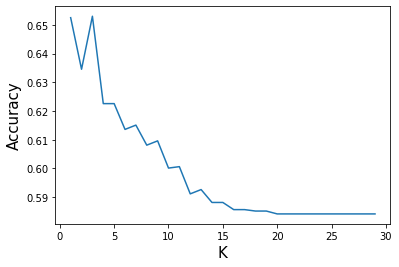

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X1_train_dtm, y_train_dtm, test_size = 0.3, random_state = 0)

scores = {}
for n in range(1, 30):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    scores[n] = knn.score(X_test, y_test)

plt.plot([key for key in scores.keys()], [value for value in scores.values()])
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('K', fontsize=15)

In [26]:
best_k = max(scores, key=scores.get)
print("Number of neighbours giving the highest accuracy: {}, Accuracy: {}".format(best_k, scores[best_k]))

Number of neighbours giving the highest accuracy: 3, Accuracy: 0.653020469296056


The value of k with which we obtained the highest score on X_test is 3. We will use this parameter for our predictions on "submitdata".

In [27]:
knn = KNeighborsClassifier(best_k)
knn.fit(X1_train_dtm, y_train_dtm)

# fill the KNN_prediction column of submitdata with the predicted values of the KNN
y_pred = knn.predict(X1_submit_dtm)
submitdata[['KNN_prediction']] = y_pred

In [28]:
# fill the KNN_prediction column of submitdata with the predicted values of the KNN
traindata[['KNN_prediction']]=knn.predict(X1_train_dtm)

In [29]:
# Save to csv, 
to_submit=submitdata[['id','KNN_prediction']]
to_submit = to_submit.rename(columns={'KNN_prediction': 'target'})
to_submit.to_csv("KNN_submit.csv", index=False, encoding = 'utf-8')

### Submission #5

k-Nearest Neighbors with k = 3: F1-score = <b>0,61758</b>

#### Multinomial Naive Bayes

In [30]:
from sklearn.naive_bayes import MultinomialNB
NB = MultinomialNB()
NB.fit(X1_train_dtm, y_train_dtm)

# fill the NB_prediction column of submitdata with the predicted values of the Naive Bayes Classifier
y_pred = NB.predict(X1_submit_dtm)
submitdata[['NB_prediction']] = y_pred


In [31]:
# fill the NB_prediction column of traindata with the predicted values of the Naive Bayes Classifier
traindata[['NB_prediction']]=NB.predict(X1_train_dtm)

In [32]:
# Save to csv, 
to_submit=submitdata[['id','NB_prediction']]
to_submit = to_submit.rename(columns={'NB_prediction': 'target'})
to_submit.to_csv("NB_submit.csv", index=False, encoding = 'utf-8')

### Submission #6

Multinomial Naive Bayes: F1-score = <b>0,80265</b>

Now we have the predictions of all the models in one single table!

In [33]:
submitdata.head(200)

,id,keyword,location,text,target,KNN_prediction,LR_prediction,RF_prediction,SVC_prediction,NB_prediction
0,0,Other,NaN,"['happen', 'terrible', 'car', 'crash']",0,0,1,1,1,1
1,2,Other,NaN,"['heard', 'earthquake', 'different', 'city', '...",0,0,1,1,1,1
2,3,Other,NaN,"['forest', 'fire', 'spot', 'pond', 'geese', 'f...",0,1,1,1,1,1
3,9,Other,NaN,"['apocalypse', 'light', 'spokane', 'wildfire']",0,0,1,1,1,1
4,11,Other,NaN,"['typhoon', 'soudelor', 'kill', 'china', 'taiw...",0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
195,629,arsonist,ss,"['new', 'fave', 'vine']",0,0,0,0,0,0
196,632,arsonist,"San Luis Obispo, California","['suspect', 'serial', 'arsonist', 'arrest', 'n...",0,0,1,1,1,1
197,634,arsonist,NaN,"['surveillance', 'video', 'capture', 'man', 'r...",0,0,0,0,0,0
198,639,arsonist,San Francisco,"['serial', 'arsonist', 'get', 'bail', 'jail', ...",0,0,0,0,0,1


In [34]:
# Save to csv
submitdata.to_csv("VOTE_submit.csv", index=False, encoding = 'utf-8')

In [35]:
traindata.head()

,id,keyword,location,text,target,KNN_prediction,LR_prediction,RF_prediction,SVC_prediction,NB_prediction
0,1,Other,NaN,"['deed', 'reason', 'earthquake', 'may', 'allah...",1,0,1,1,1,1
1,4,Other,NaN,"['forest', 'fire', 'near', 'la', 'ronge', 'sas...",1,1,1,1,1,1
2,5,Other,NaN,"['resident', 'ask', 'shelter', 'place', 'notif...",1,0,1,1,1,1
3,6,Other,NaN,"['people', 'receive', 'wildfire', 'evacuation'...",1,0,1,1,1,1
4,7,Other,NaN,"['get', 'sent', 'photo', 'ruby', 'alaska', 'sm...",1,0,1,1,1,1


In [36]:
# Save to csv
traindata.to_csv("VOTE_train.csv", index=False, encoding = 'utf-8')